In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import re

## 1 - Looking at the data

### 1.1 - Data Description
- `season`: The NFL season year. Int
- `week_num`: The week number of the NFL season. Int
- `day_of_week`: The day of the week the game was played. String
- `gametime_local`: The local time the game started. String
- `home_team`: The name of the home team. String
- `away_team`: The name of the away team. String
- `home_score`: The score of the home team. Int
- `away_score`: The score of the away team. Int
- `OT_flag`: Indicates if the game went into overtime. String (e.g., "OT" or empty)
- `arrests`: The number of arrests made during and after the game. Int
- `division_game`: Indicates if the game was a divisional matchup. String (e.g., "y" or "n")

### 1.2 - Data overview

In [119]:
# Load data
df = pd.read_csv("nfl_arrests_2011-2015.csv")
print(f"Dataset shape: {df.shape}")

Dataset shape: (1006, 11)


In [120]:
# Display the first 10 rows
display(df.head(10))

,season,week_num,day_of_week,gametime_local,home_team,away_team,home_score,away_score,OT_flag,arrests,division_game
0,2011,1,Sunday,1:15:00 PM,Arizona,Carolina,28,21,NaN,5.0,n
1,2011,4,Sunday,1:05:00 PM,Arizona,New York Giants,27,31,NaN,6.0,n
2,2011,7,Sunday,1:05:00 PM,Arizona,Pittsburgh,20,32,NaN,9.0,n
3,2011,9,Sunday,2:15:00 PM,Arizona,St. Louis,19,13,OT,6.0,y
4,2011,13,Sunday,2:15:00 PM,Arizona,Dallas,19,13,OT,3.0,n
5,2011,14,Sunday,2:05:00 PM,Arizona,San Francisco,21,19,NaN,4.0,y
6,2011,15,Sunday,2:15:00 PM,Arizona,Cleveland,20,17,OT,1.0,n
7,2011,17,Sunday,2:15:00 PM,Arizona,Seattle,23,20,OT,4.0,y
8,2012,1,Sunday,1:25:00 PM,Arizona,Seattle,20,16,NaN,0.0,y
9,2012,3,Sunday,1:05:00 PM,Arizona,Philadelphia,27,6,NaN,12.0,n


In [121]:
# Describe the data
df.describe()

,season,week_num,home_score,away_score,arrests
count,1006.000000,1006.000000,1006.000000,1006.000000,966.000000
mean,2013.000000,9.116302,23.934394,21.115308,6.566253
std,1.406453,5.008986,10.442626,9.734006,9.512101
min,2011.000000,1.000000,0.000000,0.000000,0.000000
25%,2012.000000,5.000000,17.000000,14.000000,1.000000
50%,2013.000000,9.000000,23.000000,20.000000,3.000000
75%,2014.000000,14.000000,30.000000,27.000000,8.000000
max,2015.000000,17.000000,59.000000,56.000000,69.000000


In [122]:
# Get the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          1006 non-null   int64  
 1   week_num        1006 non-null   int64  
 2   day_of_week     1006 non-null   object 
 3   gametime_local  1006 non-null   object 
 4   home_team       1006 non-null   object 
 5   away_team       1006 non-null   object 
 6   home_score      1006 non-null   int64  
 7   away_score      1006 non-null   int64  
 8   OT_flag         59 non-null     object 
 9   arrests         966 non-null    float64
 10  division_game   1006 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 86.6+ KB


From this overview of the data my first big problem appears with the amount of categorical features. There is a heavy amount of categorical data I need to convert, but most of it shouldn't be bad. I could convert the ot flag to 0 if false and 1 if true and do the same for division game. I can convert game time and day to integers as well, but converting teams through one hot encoding might make the data set to large. I need to research some ideas.

### 1.5 - Check for nulls

In [123]:
# Check for null values
nulls = df.isnull().sum()
print("\nNull values per column:")
print(nulls)


Null values per column:
season              0
week_num            0
day_of_week         0
gametime_local      0
home_team           0
away_team           0
home_score          0
away_score          0
OT_flag           947
arrests            40
division_game       0
dtype: int64


### 1.7 - Finding basic stats

In [124]:
# Games per season
print("\nGames per season:")
display(df['season'].value_counts().sort_index())


Games per season:


season
2011    199
2012    200
2013    206
2014    204
2015    197
Name: count, dtype: int64

In [125]:
# Games per day
print("\nGames per day of week:")
display(df['day_of_week'].value_counts())


Games per day of week:


day_of_week
Sunday       855
Monday        70
Thursday      64
Saturday      16
Wednesday      1
Name: count, dtype: int64

In [126]:
# Mean arrests per game
print("\nMean arrests per game:", df['arrests'].mean())


Mean arrests per game: 6.566252587991719


## 2 - Cleaning the data

This is a hard section for me because I want to fill nulls, convert, add features, and scale them all before I can start to run predications on anything

### 2.1 - Fill null values

In [127]:
# Fill null ot flag values with N
df['OT_flag'] = df['OT_flag'].fillna('N')

# Check to see if it worked
nulls = df.isnull().sum()
print("\nNull values per column:")
print(nulls)


Null values per column:
season             0
week_num           0
day_of_week        0
gametime_local     0
home_team          0
away_team          0
home_score         0
away_score         0
OT_flag            0
arrests           40
division_game      0
dtype: int64


In [128]:
# Next fill all numerical features with mean
numeric_columns = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Check to see if it worked
nulls = df.isnull().sum()
print("\nNull values per column:")
print(nulls)


Null values per column:
season            0
week_num          0
day_of_week       0
gametime_local    0
home_team         0
away_team         0
home_score        0
away_score        0
OT_flag           0
arrests           0
division_game     0
dtype: int64


Now all nulls are filled, so now we can start to convert

### 2.5 - Convert categorical to numerical

First im going to start with one hot encoding the day of the week

In [129]:
df["day_of_week"].value_counts()

day_of_week
Sunday       855
Monday        70
Thursday      64
Saturday      16
Wednesday      1
Name: count, dtype: int64

5 Values means 5 features will be add, but it is very annoying that I have to add wednesday as a feature even though it only appears once

In [130]:
# Day of week to numerical
day_encoder = OneHotEncoder(sparse_output=False)
day_encoded = day_encoder.fit_transform(df[['day_of_week']])
day_encoded_df = pd.DataFrame(day_encoded, columns=[f'day_{cat}' for cat in day_encoder.categories_[0]])
df = pd.concat([df, day_encoded_df], axis=1)
df.drop('day_of_week', axis=1, inplace=True)

display(df.head(10))

,season,week_num,gametime_local,home_team,away_team,home_score,away_score,OT_flag,arrests,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday
0,2011.0,1.0,1:15:00 PM,Arizona,Carolina,28.0,21.0,N,5.0,n,0.0,0.0,1.0,0.0,0.0
1,2011.0,4.0,1:05:00 PM,Arizona,New York Giants,27.0,31.0,N,6.0,n,0.0,0.0,1.0,0.0,0.0
2,2011.0,7.0,1:05:00 PM,Arizona,Pittsburgh,20.0,32.0,N,9.0,n,0.0,0.0,1.0,0.0,0.0
3,2011.0,9.0,2:15:00 PM,Arizona,St. Louis,19.0,13.0,OT,6.0,y,0.0,0.0,1.0,0.0,0.0
4,2011.0,13.0,2:15:00 PM,Arizona,Dallas,19.0,13.0,OT,3.0,n,0.0,0.0,1.0,0.0,0.0
5,2011.0,14.0,2:05:00 PM,Arizona,San Francisco,21.0,19.0,N,4.0,y,0.0,0.0,1.0,0.0,0.0
6,2011.0,15.0,2:15:00 PM,Arizona,Cleveland,20.0,17.0,OT,1.0,n,0.0,0.0,1.0,0.0,0.0
7,2011.0,17.0,2:15:00 PM,Arizona,Seattle,23.0,20.0,OT,4.0,y,0.0,0.0,1.0,0.0,0.0
8,2012.0,1.0,1:25:00 PM,Arizona,Seattle,20.0,16.0,N,0.0,y,0.0,0.0,1.0,0.0,0.0
9,2012.0,3.0,1:05:00 PM,Arizona,Philadelphia,27.0,6.0,N,12.0,n,0.0,0.0,1.0,0.0,0.0


Next is teams

In [131]:
df["home_team"].value_counts()

home_team
Arizona            40
Carolina           40
Green Bay          40
Cincinnati         40
Dallas             40
Denver             40
Houston            40
Detroit            40
New York Jets      40
Indianapolis       40
Seattle            40
Tennessee          40
New York Giants    40
New England        40
San Francisco      40
San Diego          40
Pittsburgh         40
Philadelphia       40
Washington         40
Kansas City        39
Tampa Bay          39
Jacksonville       37
Oakland            37
Chicago            32
Baltimore          31
Miami              31
Name: count, dtype: int64

There is defiantly too many teams here to one hot encode because I have to do away and home. After researching only I think label encoding will work the best out of my options. How this will work is it will assign each home and away team a integer value that will correspond to the team. It shouldn't be to bad to make it work for this.

In [132]:
# Team encoding
all_teams = sorted(set(df['home_team'].unique()).union(set(df['away_team'].unique())))
team_to_id = {team: idx for idx, team in enumerate(all_teams)}

df['home_team_id'] = df['home_team'].map(team_to_id)
df['away_team_id'] = df['away_team'].map(team_to_id)
df.drop(['home_team', 'away_team'], axis=1, inplace=True)

display(df.head(10))

,season,week_num,gametime_local,home_score,away_score,OT_flag,arrests,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id
0,2011.0,1.0,1:15:00 PM,28.0,21.0,N,5.0,n,0.0,0.0,1.0,0.0,0.0,0,4
1,2011.0,4.0,1:05:00 PM,27.0,31.0,N,6.0,n,0.0,0.0,1.0,0.0,0.0,0,20
2,2011.0,7.0,1:05:00 PM,20.0,32.0,N,9.0,n,0.0,0.0,1.0,0.0,0.0,0,24
3,2011.0,9.0,2:15:00 PM,19.0,13.0,OT,6.0,y,0.0,0.0,1.0,0.0,0.0,0,28
4,2011.0,13.0,2:15:00 PM,19.0,13.0,OT,3.0,n,0.0,0.0,1.0,0.0,0.0,0,8
5,2011.0,14.0,2:05:00 PM,21.0,19.0,N,4.0,y,0.0,0.0,1.0,0.0,0.0,0,26
6,2011.0,15.0,2:15:00 PM,20.0,17.0,OT,1.0,n,0.0,0.0,1.0,0.0,0.0,0,7
7,2011.0,17.0,2:15:00 PM,23.0,20.0,OT,4.0,y,0.0,0.0,1.0,0.0,0.0,0,27
8,2012.0,1.0,1:25:00 PM,20.0,16.0,N,0.0,y,0.0,0.0,1.0,0.0,0.0,0,27
9,2012.0,3.0,1:05:00 PM,27.0,6.0,N,12.0,n,0.0,0.0,1.0,0.0,0.0,0,23


In [133]:
# Print out the table of the id with the team
team_encoding_df = pd.DataFrame(list(team_to_id.items()), columns=['Team', 'Team_ID'])
display(team_encoding_df.sort_values('Team_ID'))

,Team,Team_ID
0,Arizona,0
1,Atlanta,1
2,Baltimore,2
3,Buffalo,3
4,Carolina,4
5,Chicago,5
6,Cincinnati,6
7,Cleveland,7
8,Dallas,8
9,Denver,9


Label encoding worked great here and now I just have to fix a couple more values and I should be done with converting soon

In [134]:
# Convert OT_flag and division_game to 0 and 1
df['overtime'] = df['OT_flag'].apply(lambda x: 1 if x == 'OT' else 0)
df.drop('OT_flag', axis=1, inplace=True)

# Convert division_game
df['division_game'] = df['division_game'].apply(lambda x: 1 if x.lower() == 'y' else 0)

# Check if worked
display(df.head(10))

,season,week_num,gametime_local,home_score,away_score,arrests,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id,overtime
0,2011.0,1.0,1:15:00 PM,28.0,21.0,5.0,0,0.0,0.0,1.0,0.0,0.0,0,4,0
1,2011.0,4.0,1:05:00 PM,27.0,31.0,6.0,0,0.0,0.0,1.0,0.0,0.0,0,20,0
2,2011.0,7.0,1:05:00 PM,20.0,32.0,9.0,0,0.0,0.0,1.0,0.0,0.0,0,24,0
3,2011.0,9.0,2:15:00 PM,19.0,13.0,6.0,1,0.0,0.0,1.0,0.0,0.0,0,28,1
4,2011.0,13.0,2:15:00 PM,19.0,13.0,3.0,0,0.0,0.0,1.0,0.0,0.0,0,8,1
5,2011.0,14.0,2:05:00 PM,21.0,19.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,26,0
6,2011.0,15.0,2:15:00 PM,20.0,17.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0,7,1
7,2011.0,17.0,2:15:00 PM,23.0,20.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,27,1
8,2012.0,1.0,1:25:00 PM,20.0,16.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0,27,0
9,2012.0,3.0,1:05:00 PM,27.0,6.0,12.0,0,0.0,0.0,1.0,0.0,0.0,0,23,0


Lastly I need to convert game time to numerical. This turned out to be pretty hard because I tried to convert to hours and just round, but that didn't work at all and messed up the data anyways. After looking online for a bit I found the re library and a stack overflow question with basically the same problem and just used the function in there and it worked great.

In [135]:
# Convert game time
def time_to_minutes(time_str):
    match = re.search(r'(\d+):(\d+):(\d+)\s*([AP]M)', time_str)
    if match:
        hour, minute, second, period = match.groups()
        hour = int(hour)
        if period == 'PM' and hour < 12:
            hour += 12
        elif period == 'AM' and hour == 12:
            hour = 0
        return hour * 60 + int(minute)
    return None

df['game_minutes'] = df['gametime_local'].apply(time_to_minutes)
df.drop('gametime_local', axis=1, inplace=True)

# Check if worked
display(df.head(10))

,season,week_num,home_score,away_score,arrests,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id,overtime,game_minutes
0,2011.0,1.0,28.0,21.0,5.0,0,0.0,0.0,1.0,0.0,0.0,0,4,0,795
1,2011.0,4.0,27.0,31.0,6.0,0,0.0,0.0,1.0,0.0,0.0,0,20,0,785
2,2011.0,7.0,20.0,32.0,9.0,0,0.0,0.0,1.0,0.0,0.0,0,24,0,785
3,2011.0,9.0,19.0,13.0,6.0,1,0.0,0.0,1.0,0.0,0.0,0,28,1,855
4,2011.0,13.0,19.0,13.0,3.0,0,0.0,0.0,1.0,0.0,0.0,0,8,1,855
5,2011.0,14.0,21.0,19.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,26,0,845
6,2011.0,15.0,20.0,17.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0,7,1,855
7,2011.0,17.0,23.0,20.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,27,1,855
8,2012.0,1.0,20.0,16.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0,27,0,805
9,2012.0,3.0,27.0,6.0,12.0,0,0.0,0.0,1.0,0.0,0.0,0,23,0,785


Now after all the conversion I got every feature to numerical and I didn't have to use one hot encoding much so the data set isn't extremely big either. Now I want to add a couple more features to help the future analysis.

### 2.7 - Feature engineering

For the features I decided I want to add I went with total points, score difference, home team win, high scoring, and game competitiveness all of which will be explained in more code comments when in their cells.

In [136]:
# First is total points which is just home + away points added together
df['total_points'] = df['home_score'] + df['away_score']

In [137]:
# Next is score difference which is the difference between the two teams scoring
df['score_diff'] = df['home_score'] - df['away_score']

In [138]:
# Now home team win is added which is just seeing whether the home team won and if they did a 1 is recorded and if not a 0 is recorded
df['home_win'] = (df['score_diff'] > 0).astype(int)

In [139]:
# Next is high scoring which finds the average score of the games and if it is above records a 1 and if not it records a 0
median_score = df['total_points'].median()
df['high_scoring'] = (df['total_points'] > median_score).astype(int)

In [140]:
# Lastly is game competitiveness which uses how close the score was to find if they game was competitive
df['competitive_game'] = 1 - (abs(df['score_diff']) / df['total_points'])

Now we can check if they all worked

In [141]:
display(df.head(10))

,season,week_num,home_score,away_score,arrests,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id,overtime,game_minutes,total_points,score_diff,home_win,high_scoring,competitive_game
0,2011.0,1.0,28.0,21.0,5.0,0,0.0,0.0,1.0,0.0,0.0,0,4,0,795,49.0,7.0,1,1,0.857143
1,2011.0,4.0,27.0,31.0,6.0,0,0.0,0.0,1.0,0.0,0.0,0,20,0,785,58.0,-4.0,0,1,0.931034
2,2011.0,7.0,20.0,32.0,9.0,0,0.0,0.0,1.0,0.0,0.0,0,24,0,785,52.0,-12.0,0,1,0.769231
3,2011.0,9.0,19.0,13.0,6.0,1,0.0,0.0,1.0,0.0,0.0,0,28,1,855,32.0,6.0,1,0,0.812500
4,2011.0,13.0,19.0,13.0,3.0,0,0.0,0.0,1.0,0.0,0.0,0,8,1,855,32.0,6.0,1,0,0.812500
5,2011.0,14.0,21.0,19.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,26,0,845,40.0,2.0,1,0,0.950000
6,2011.0,15.0,20.0,17.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0,7,1,855,37.0,3.0,1,0,0.918919
7,2011.0,17.0,23.0,20.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0,27,1,855,43.0,3.0,1,0,0.930233
8,2012.0,1.0,20.0,16.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0,27,0,805,36.0,4.0,1,0,0.888889
9,2012.0,3.0,27.0,6.0,12.0,0,0.0,0.0,1.0,0.0,0.0,0,23,0,785,33.0,21.0,1,0,0.363636


It looks perfect and now that those features are added its finally time to scale

### 2.7 - Splitting and Scaling

I forgot I need to split my data before so im going to do that quickly and then scale

In [142]:
# Define target variable and features
y = df['arrests']
X = df.drop('arrests', axis=1)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (804, 19)
Testing set shape: (202, 19)


Now I can actually scale

In [143]:
# Define which ones to scale because no point in scale the 0 and 1 columns
cols_to_scale = ['season', 'week_num', 'home_score', 'away_score', 
                'game_minutes', 'total_points', 'score_diff', 'competitive_game']

# Create and fit scaler using training data
scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Apply the same to the test data
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])


Now that the training and test data is scaled I can output the head for each and see if I can finally be done with cleaning

In [144]:
print("Final training data after cleaning: ")
display(X_train.head(3))

print("Final test data after cleaning: ")
display(X_test.head(3))

Final training data after cleaning: 


,season,week_num,home_score,away_score,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id,overtime,game_minutes,total_points,score_diff,home_win,high_scoring,competitive_game
29,0.733208,0.400003,-0.967922,-1.551597,0,0.0,0.0,1.0,0.0,0.0,0,10,0,-0.052106,-1.842518,0.343751,1,0,-0.522450
280,0.020392,-0.994804,1.533740,1.110685,1,0.0,0.0,1.0,0.0,0.0,10,5,0,-0.565137,1.957590,0.343751,1,1,0.748763
507,0.020392,-1.194062,0.282909,0.189126,0,0.0,0.0,1.0,0.0,0.0,16,1,0,0.551460,0.349852,0.073787,1,1,0.885663


Final test data after cleaning: 


,season,week_num,home_score,away_score,division_game,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Wednesday,home_team_id,away_team_id,overtime,game_minutes,total_points,score_diff,home_win,high_scoring,competitive_game
927,-1.405242,-1.194062,-0.679269,-0.732433,0,0.0,0.0,1.0,0.0,0.0,30,9,0,-0.927277,-1.038649,0.006296,1,0,0.811850
630,0.020392,0.001487,0.186691,-0.118060,0,0.0,0.0,1.0,0.0,0.0,21,19,0,-0.565137,0.057536,0.208769,1,1,0.663732
682,1.446025,-0.197771,0.956433,-0.118060,0,0.0,0.0,1.0,0.0,0.0,22,21,0,-0.534959,0.642168,0.748697,1,1,0.096859


It looks good and now I am finally done with cleaning.

A quick summary of what I did with part 2 was I filled all nulls, converted all categorical data to numerical with one hot encoding and label encoding, I split the data into test and training data and made sure my target (arrests) was not included, I also added 5 new features to help with future analysis, and lastly I scaled both the test and training data. 

## 3 - Early model predictions

Firstly, I want to look at the target variable more closely to help my future predictions

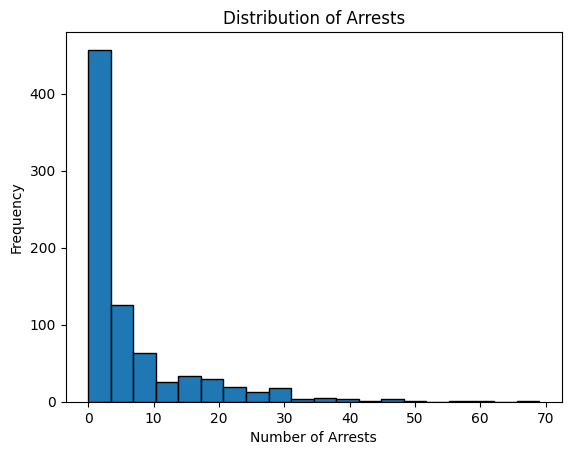

In [145]:
# Visualize arrests
import matplotlib.pyplot as plt
plt.hist(y_train, bins=20, edgecolor='black')
plt.title('Distribution of Arrests')
plt.xlabel('Number of Arrests')
plt.ylabel('Frequency')
plt.show()

From the graph you can see the mass majority of the arrests fall into the 0 - 10 range. This will be important in the future

Next, I want to make a feature correlation to see which features impact it the most

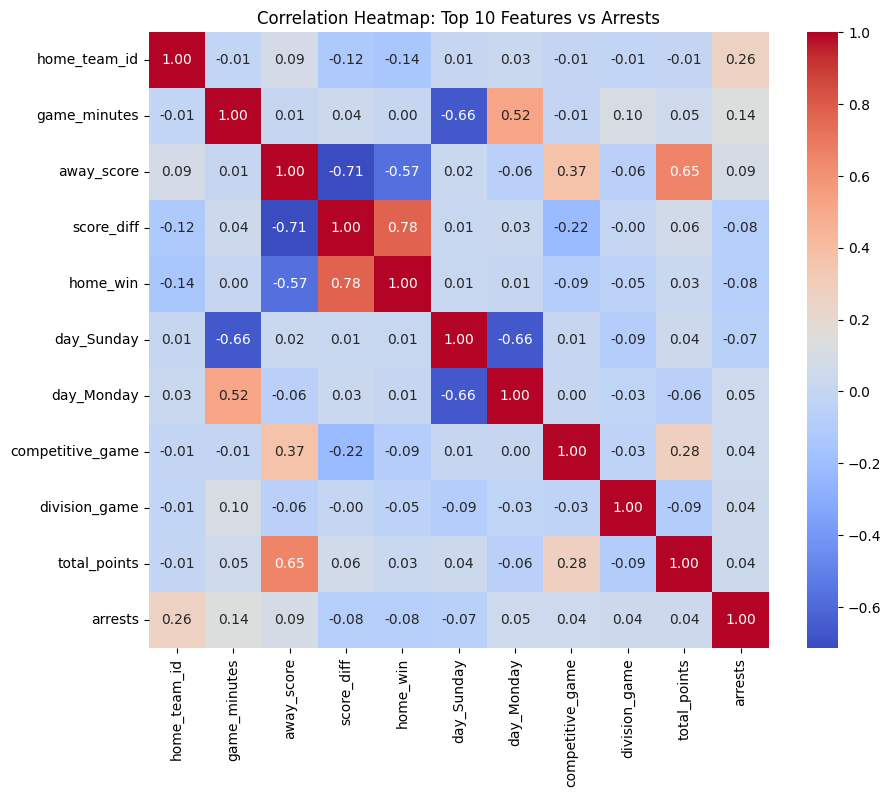

In [146]:
# Make the correlation matrix and the features
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()
top_features = correlation_matrix['arrests'].abs().sort_values(ascending=False)[1:11].index.tolist()
top_corr = correlation_matrix.loc[top_features + ['arrests'], top_features + ['arrests']]

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Top 10 Features vs Arrests')
plt.show()

From this graph you can see a lot of interesting features. Home team winning, total points, game minutes, and away score lead to a lot of violence the more they increase. While oddly Sunday seems to see a lot less arrests than Monday games for example.

In [147]:
correlation_matrix = X_train.corr()
target_correlations = pd.concat([X_train, y_train], axis=1).corr()['arrests'].sort_values(key=abs, ascending=False)
print("Features most correlated with arrests:")
print(target_correlations[1:11])

Features most correlated with arrests:
home_team_id        0.262306
game_minutes        0.138760
away_score          0.091237
score_diff         -0.084700
home_win           -0.083624
day_Sunday         -0.065815
day_Monday          0.047600
competitive_game    0.042307
division_game       0.038811
total_points        0.038518
Name: arrests, dtype: float64


Now after learning more about the data and features im ready to start with training the model

Im going to start with linear regression and depending on how it does I wil try and improve or change to a different model

In [148]:
# Simple linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Linear Regression Results:")
print(f"RMSE: {root_mean_squared_error(y_test, lr_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, lr_pred):.3f}")
print(f"R2: {r2_score(y_test, lr_pred):.3f}")

Linear Regression Results:
RMSE: 8.948
MAE: 6.340
R2: 0.097


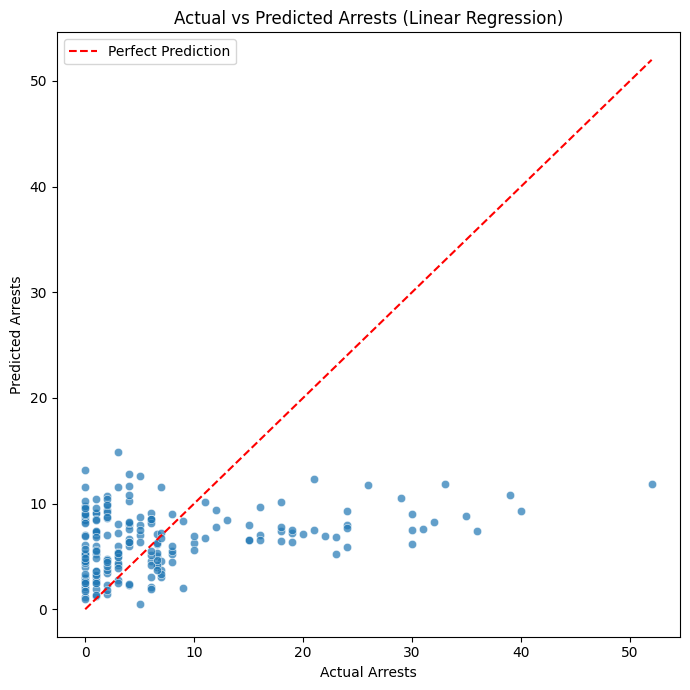

In [149]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=lr_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Arrests')
plt.ylabel('Predicted Arrests')
plt.title('Actual vs Predicted Arrests (Linear Regression)')
plt.legend()
plt.tight_layout()
plt.show()

Linear regression definitely doesn't work. Im going to try random forest to see if that can help

In [150]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Results:")
print(f"RMSE: {root_mean_squared_error(y_test, rf_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.3f}")
print(f"R²: {r2_score(y_test, rf_pred):.3f}")

Random Forest Results:
RMSE: 5.440
MAE: 3.401
R²: 0.666


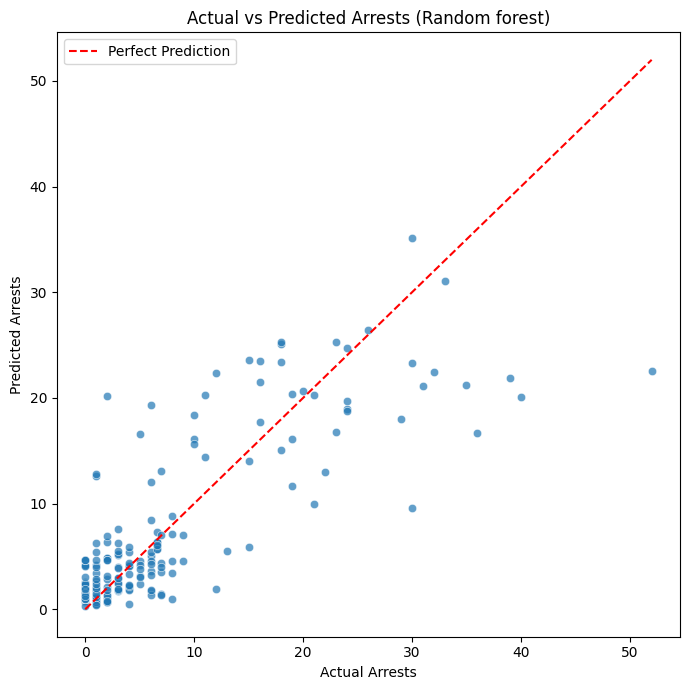

In [151]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=rf_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Arrests')
plt.ylabel('Predicted Arrests')
plt.title('Actual vs Predicted Arrests (Random forest)')
plt.legend()
plt.tight_layout()
plt.show()